# Availability of adult and pediatric ICU beds and occupancy for COVID-related critical illness (CRCI)

## 1.0 Data Preparation

### 1.1 Data Import

This dataset comes from [Ontario Data Catalogue](https://data.ontario.ca/en/dataset/availability-of-adult-icu-beds-and-occupancy-for-covid-related-critical-illness-crci) and it compiles daily counts of patients (both COVID-related and non-COVID-related) in adult and pediatric ICU beds and the number of adult and pediatric ICU beds that are unoccupied.

In [1]:
# Set up modules.
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns

from matplotlib import pyplot as plt, dates as mdates
from statsmodels.graphics.tsaplots import plot_acf
from custom_functions import set_timeline

In [2]:
# Import the csv file using `date` as index.
df_icu_beds = pd.read_csv('../data/icu_beds.csv', index_col = 'date')

# Set global figure dpi.
plt.rcParams["figure.dpi"] = 100

### 1.2 Data Inspection
The earliest record is dated May 1, 2020 and the latest Feb 2, 2023. There is no missing daily entry since the dataset spans 1008 days and there are 1008 records. There is no missing data in any column of the DataFrame. The following features are included:

| Name                          | Description                                                                   |
| :--                           | :--                                                                           |
| `adult_icu_crci_patients`     | number of adults in ICU for COVID-related critical illness (CRCI)             |
| `adult_icu_non_crci_patients` | number of adults in ICU for non-CRCI reasons                                  |
| `available_adult_icu_beds`    | number of adult ICU beds that are unoccupied                                  |
| `total_adult_icu_patients`    | total number of adults in ICU for any reason                                  |
| `total_adult_icu_beds`        | total number of adult ICU beds                                                |
| `ped_icu_crci_patients`       | number of patients in pediatric ICU for COVID-related critical illness (CRCI) |
| `ped_icu_non_crci_patients`   | number of patients in pediatric ICU beds for non-CRCI reasons                 |
| `available_ped_icu_beds`      | number of pediatric ICU beds that are unoccupied                              |
| `total_ped_icu_patients`      | total number of patients in pediatric ICU beds for any reason                 |
| `total_ped_icu_beds `         | total number of pediatric ICU beds                                            |

In [3]:
df_icu_beds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1008 entries, 2020-05-01 to 2023-02-02
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   adult_icu_crci_patients      1008 non-null   int64
 1   adult_icu_non_crci_patients  1008 non-null   int64
 2   available_adult_icu_beds     1008 non-null   int64
 3   total_adult_icu_patients     1008 non-null   int64
 4   total_adult_icu_beds         1008 non-null   int64
 5   ped_icu_crci_patients        1008 non-null   int64
 6   ped_icu_non_crci_patients    1008 non-null   int64
 7   available_ped_icu_beds       1008 non-null   int64
 8   total_ped_icu_patients       1008 non-null   int64
 9   total_ped_icu_beds           1008 non-null   int64
dtypes: int64(10)
memory usage: 86.6+ KB


In [4]:
# Since all features relate to ICU, the `icu_` substring can be dropped from all column names for ease of coding.
df_icu_beds.columns = df_icu_beds.columns.str.replace('icu_', '')
df_icu_beds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1008 entries, 2020-05-01 to 2023-02-02
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   adult_crci_patients      1008 non-null   int64
 1   adult_non_crci_patients  1008 non-null   int64
 2   available_adult_beds     1008 non-null   int64
 3   total_adult_patients     1008 non-null   int64
 4   total_adult_beds         1008 non-null   int64
 5   ped_crci_patients        1008 non-null   int64
 6   ped_non_crci_patients    1008 non-null   int64
 7   available_ped_beds       1008 non-null   int64
 8   total_ped_patients       1008 non-null   int64
 9   total_ped_beds           1008 non-null   int64
dtypes: int64(10)
memory usage: 86.6+ KB


In [5]:
# Check if there is any missing daily entry.
dates = pd.to_datetime(df_icu_beds.index)
(dates[-1] - dates[0]).days + 1

1008

For each group of patients, the following relations exist between features:
- number of CRCI patients + number of Non-CRCI patients = total number of patients
- number of available beds + total number of patients (i.e. total number of beds occupied) = total number of beds

In [6]:
# Check the aforementioned relations.
print(
    ((df_icu_beds['adult_crci_patients'] + df_icu_beds['adult_non_crci_patients']) == df_icu_beds['total_adult_patients']).all(),
    ((df_icu_beds['available_adult_beds'] + df_icu_beds['total_adult_patients']) == df_icu_beds['total_adult_beds']).all(),
    ((df_icu_beds['ped_crci_patients'] + df_icu_beds['ped_non_crci_patients']) == df_icu_beds['total_ped_patients']).all(),
    ((df_icu_beds['available_ped_beds'] + df_icu_beds['total_ped_patients']) == df_icu_beds['total_ped_beds']).all()
)

True True True True


In [7]:
# Convert the indices to pandas datetime objects in preparation for plotting.
df_icu_beds.index = pd.to_datetime(df_icu_beds.index)

# Create a list of row indices corresponding to first yearly entries for setting the major x-axis ticks in time series plots.
index_1st_yearly_entry = df_icu_beds[~df_icu_beds.index.year.duplicated()].index

## 2.0 EDA

### 2.1 Adult versus pediatric CRCI patients

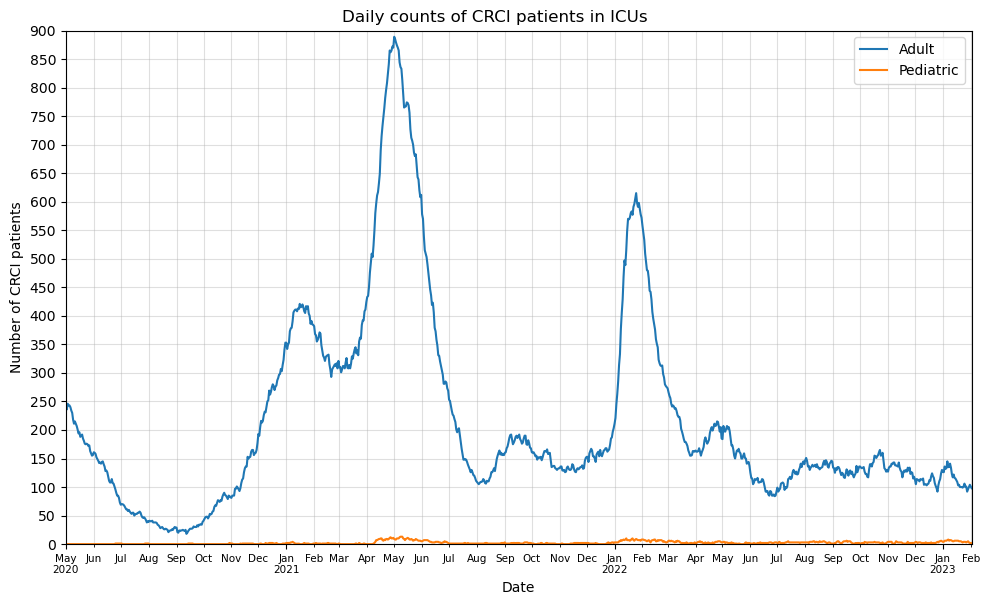

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_icu_beds[['adult_crci_patients', 'ped_crci_patients']])
ax.legend(['Adult', 'Pediatric'])
ax.grid(which='both', alpha=0.4)
ax.set(xlabel='Date', xlim=(dates[0], dates[-1]), xticks=index_1st_yearly_entry,
       ylabel='Number of CRCI patients', ylim=(0, 900), yticks=np.arange(0,960,50))
set_timeline(ax)

fig.suptitle('Daily counts of CRCI patients in ICUs', y=1)
fig.tight_layout()
fig.savefig('../output/crci_patients_by_age_group.png', bbox_inches='tight')

## 2.2 Correlation of the features in the ICU beds dataset

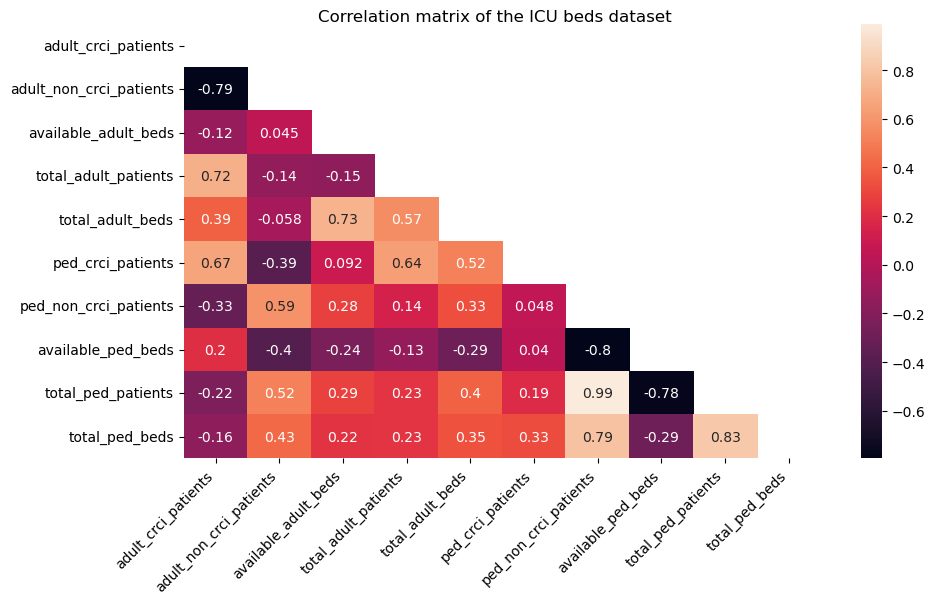

In [9]:
corr_matrix = df_icu_beds.corr()
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(df_icu_beds.corr(), ax=ax, mask=mask, annot=True)
ax.set_xticklabels(labels=corr_matrix.columns, rotation=45, ha='right')

fig.suptitle('Correlation matrix of the ICU beds dataset', y=1)
fig.tight_layout()
fig.savefig('../output/correlation_matrix.png', bbox_inches='tight')

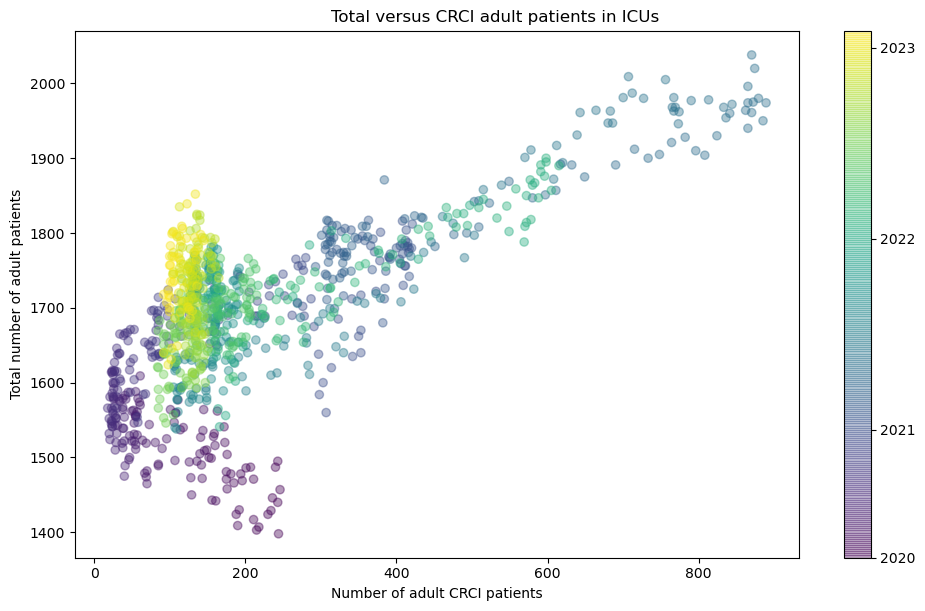

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
sc = ax.scatter(x=df_icu_beds.adult_crci_patients, y=df_icu_beds.total_adult_patients,
                c=mdates.date2num(df_icu_beds.index), alpha=0.4)
ax.set(xlabel='Number of adult CRCI patients',
       ylabel='Total number of adult patients')
cbar = fig.colorbar(sc, ticks=mdates.date2num(index_1st_yearly_entry))
cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y'))

fig.suptitle('Total versus CRCI adult patients in ICUs', y=1.01)
fig.tight_layout()
fig.savefig('../output/adult_total_vs_crci.png', bbox_inches='tight')

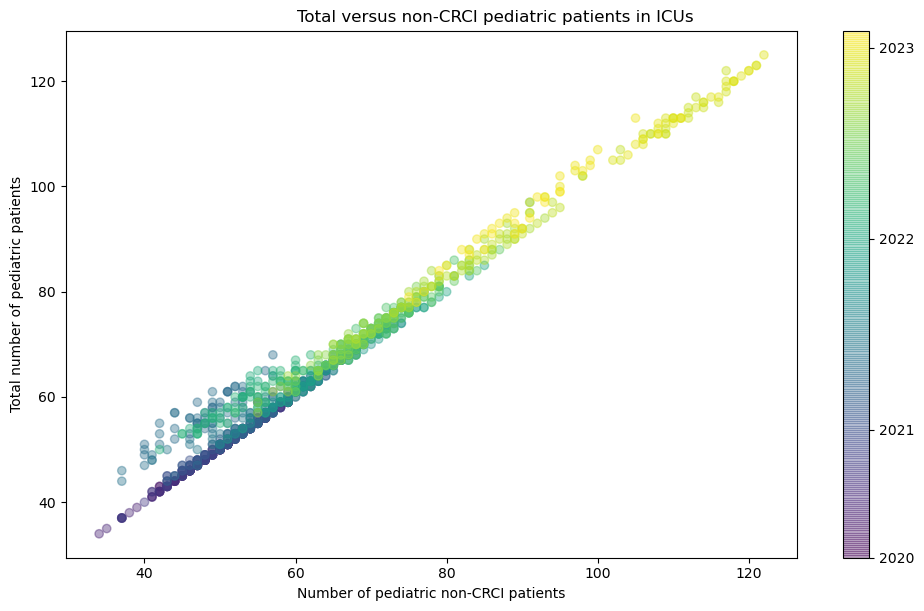

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
sc = ax.scatter(x=df_icu_beds.ped_non_crci_patients, y=df_icu_beds.total_ped_patients,
                c=mdates.date2num(df_icu_beds.index), alpha=0.4)
ax.set(xlabel='Number of pediatric non-CRCI patients',
       ylabel='Total number of pediatric patients')
cbar = fig.colorbar(sc, ticks=mdates.date2num(index_1st_yearly_entry))
cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y'))

fig.suptitle('Total versus non-CRCI pediatric patients in ICUs', y=1.01)
fig.tight_layout()
fig.savefig('../output/pediatric_total_vs_non_crci.png', bbox_inches='tight')

### 2.3 Availability of ICU beds

- plot description
    - The line plots chart the daily counts of available beds in ICUs from 2020-05 to 2023-02.
- plot features
    - The blue line represents available beds for adult patients and the orange line available beds for pediatric patients.
- observations
    - There was never shortage of available ICU beds for adults.
    - The same cannot be said about pediatric patients. Due to the recent steady increase in non-CRCI pediatric patients in ICUS, there was a period of 9 days last November when there were not enough ICU beds for pediatric patients.

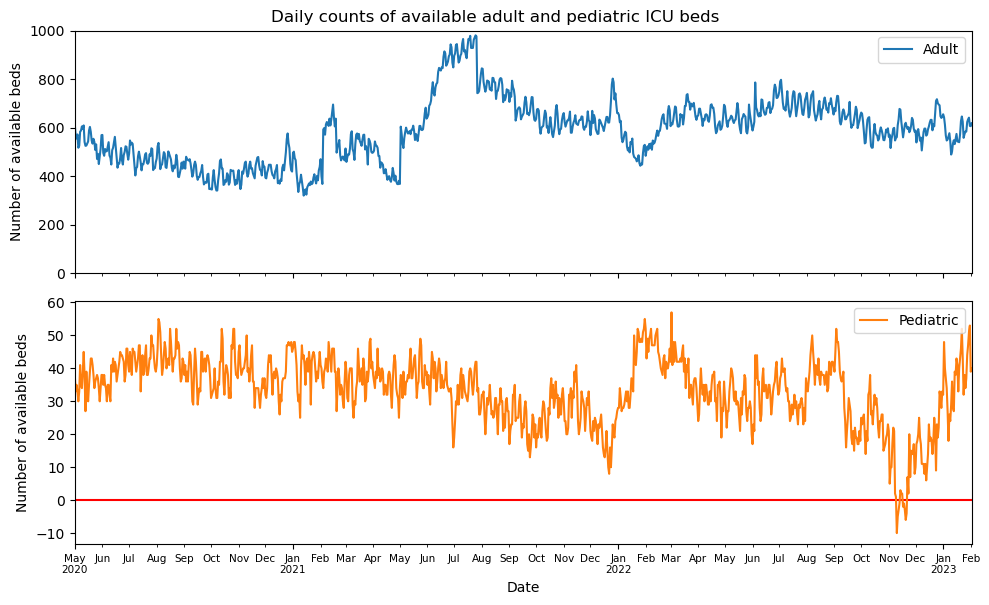

In [12]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 6))

ax[0].plot(df_icu_beds['available_adult_beds'])
ax[0].legend(['Adult'], loc='upper right')
ax[0].set(ylabel='Number of available beds', ylim=(0, 1000))

ax[1].plot(df_icu_beds['available_ped_beds'], color='C1')
ax[1].hlines(y=0, xmin=df_icu_beds.index[0], xmax=df_icu_beds.index[-1], color='red')
ax[1].legend(['Pediatric'], loc='upper right')
ax[1].set(xlabel='Date', xlim=(dates[0], dates[-1]), xticks=index_1st_yearly_entry,
          ylabel='Number of available beds')
set_timeline(ax[1])

fig.suptitle('Daily counts of available adult and pediatric ICU beds', y=1)
fig.tight_layout()
fig.savefig('../output/available_icu_beds.png', bbox_inches='tight')

In [13]:
print(f'There were a total of {(df_icu_beds.available_ped_beds<0).sum()} days when there were not enough ICU beds for pediatric patients.')

There were a total of 9 days when there were not enough ICU beds for pediatric patients.


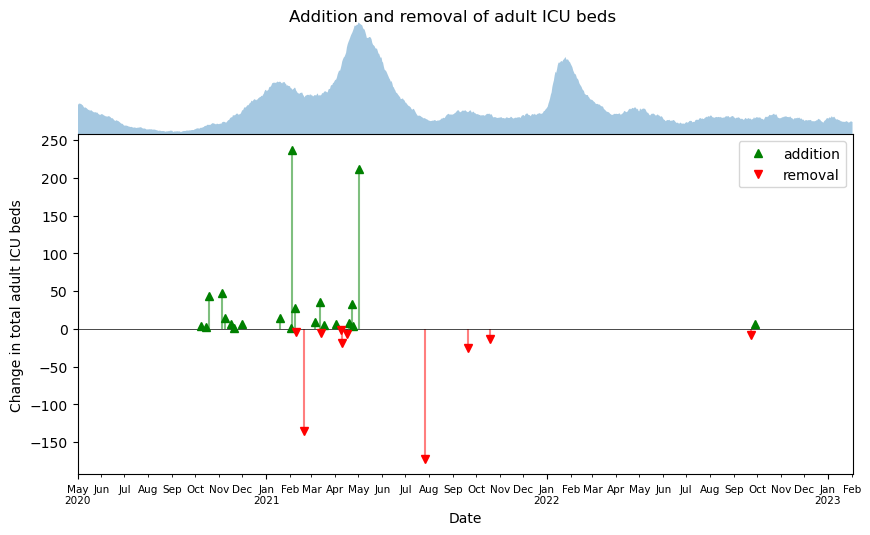

In [14]:
diff = df_icu_beds.iloc[1:] - df_icu_beds.shift().iloc[1:]

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 3]})
fig.subplots_adjust(hspace=0)

ax[0].fill_between(df_icu_beds.index, df_icu_beds['adult_crci_patients'], alpha=0.4)
ax[0].set(ylim=(0,900))
ax[0].axis('off')

ax[1].axhline(color='black', linewidth=0.5)
# Plot the addition of ICU beds.
ax[1].vlines(diff[diff.total_adult_beds>0].index, 0, diff[diff.total_adult_beds>0].total_adult_beds, color='green', alpha=0.5)
ax[1].plot(diff[diff.total_adult_beds>0].index, diff[diff.total_adult_beds>0].total_adult_beds, 
                 linestyle='None', color='green', marker='^', label='addition')
# Plot the removal of ICU beds. 
ax[1].vlines(diff[diff.total_adult_beds<0].index, 0, diff[diff.total_adult_beds<0].total_adult_beds, color='red', alpha=0.5)
ax[1].plot(diff[diff.total_adult_beds<0].index, diff[diff.total_adult_beds<0].total_adult_beds, 
                 linestyle='None', color='red', marker='v', label='removal')
ax[1].legend()
ax[1].set(xlabel='Date', xlim=(dates[0], dates[-1]), xticks=index_1st_yearly_entry, ylabel='Change in total adult ICU beds')
set_timeline(ax[1])

fig.suptitle('Addition and removal of adult ICU beds', y=0.9)
fig.savefig('../output/changes_in_total_adult_icu_beds.png', bbox_inches='tight')

### 2.4 Autocorrelation of adult CRCI patients

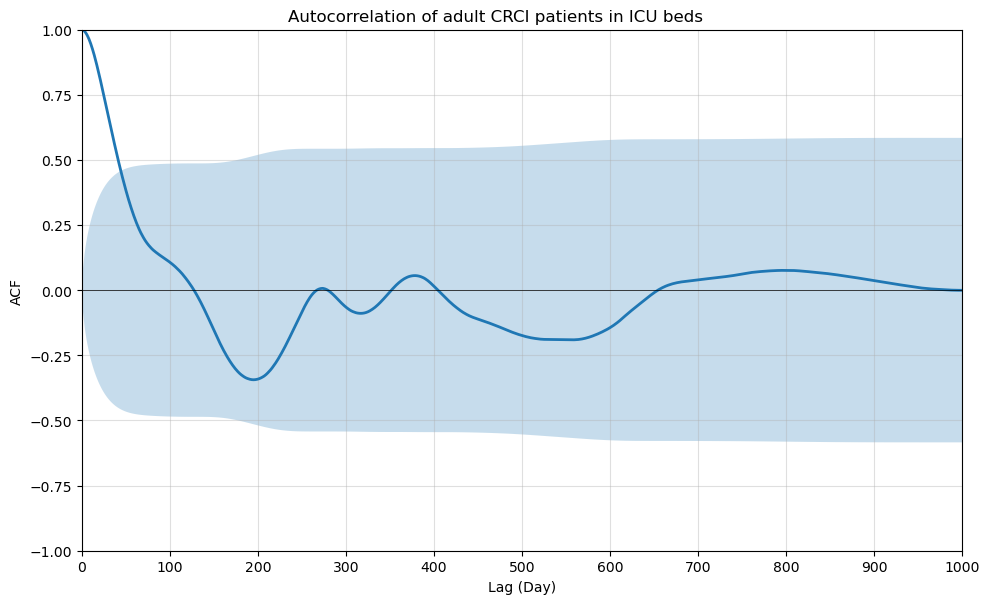

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(df_icu_beds.adult_crci_patients,
         zero=False, lags=1007, ax=ax, 
         marker=None, use_vlines=False, linestyle='-', linewidth=2, title=None)
# can configure the vertical lines connecting each autocorrelation to the axis as follows:
# marker=None, vlines_kwargs = {'linewidth':0.5, 'alpha':0.5}
ax.axhline(color='black', linewidth=0.5)
ax.grid(alpha=0.4)
ax.set(xticks=np.linspace(0,1000,11), xlim=[0, 1000], xlabel='Lag (Day)', ylabel='ACF')

fig.suptitle('Autocorrelation of adult CRCI patients in ICU beds', y=1)
fig.tight_layout()
fig.savefig('../output/acf_adult_crci_patients.png', bbox_inches='tight')